In [1]:
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.torch_core import uniform_int
import PIL
import glob
import re

### Create directory structure in ImageNet format

This will allow us to take advantage of the tools in the fastai library.

In [3]:
def loadChunkedData(infile):
    with open(infile, 'rb') as f:
        d = pickle.load(f)
        #(X_train, y_train, pageinfo_train, X_valid, y_valid, pageinfo_valid, X_test, y_test, pageinfo_test) = d       
    #return X_train, y_train, X_valid, y_valid, X_test, y_test
    return d

In [4]:
def getComposer2IndexMapping(feat_dir = 'score_feat'):
    composers = []
    for composerDir in sorted(glob.glob('{}/*/'.format(feat_dir))):
        composer = composerDir.split('/')[-2]
        composers.append(composer)
    c_to_i = {c:i for i, c in enumerate(composers)}
    
    return c_to_i, composers

In [5]:
def createDirectoryStructure(X, y, composers, dirType, outdir):
    for c in composers:
        composerDir = '{}/{}/{}/'.format(outdir, dirType, c)
        os.makedirs(composerDir)
    for i in range(X.shape[0]):
        composer = composers[y[i]]
        outfile = '{}/{}/{}/{}_{}.png'.format(outdir, dirType, composer, dirType, i)
        saveToPng(X[i,:,:], outfile)

In [6]:
def saveToPng(img, outfile):
    img = np.uint8(img.astype(np.float) * 255)
    pim = PIL.Image.fromarray(img)
    pim.save(outfile)

In [7]:
chunk_data_file = 'score_feat/data.chunks.pkl'
data_dir = 'score_feat_imagenet'

In [8]:
_, composers = getComposer2IndexMapping()
#X_train, y_train, X_valid, y_valid, X_test, y_test = loadChunkedData(chunk_data_file)
(X_train, y_train, pageinfo_train, X_valid, y_valid, pageinfo_valid, X_test, y_test, pageinfo_test) = loadChunkedData(chunk_data_file)

In [12]:
#createDirectoryStructure(X_train, y_train, composers, 'train', data_dir)
#createDirectoryStructure(X_valid, y_valid, composers, 'valid', data_dir)
#createDirectoryStructure(X_test, y_test, composers, 'test', data_dir)

### Train model

Perform random crops and pitch shifts for data augmentation.

In [9]:
def _rand_shift(x, shift:uniform_int=0):
    "Cyclically shift the image in the vertical direction."
    shifted = np.roll(np.array(x), shift, axis=1)
    return tensor(np.ascontiguousarray(shifted))
rand_shift = TfmPixel(_rand_shift)

In [10]:
tfms_train = [crop(size=(62,64), row_pct=0.5, col_pct=(0,1)), rand_shift(shift=(-3,3))] # random crop + shift
tfms_eval = [crop(size=(62,64), row_pct=0.5, col_pct=0.5)] # middle crop, no shift
data = ImageDataBunch.from_folder(data_dir, test='test', ds_tfms = (tfms_train, tfms_eval))
getattr(data, 'train_dl').x.convert_mode = "L" # read images as grayscale
getattr(data, 'valid_dl').x.convert_mode = "L"
getattr(data, 'test_dl').x.convert_mode = "L"

In [48]:
class LSTM_Net(nn.Module):
    def __init__(self):
        super(LSTM_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, (8,1), 1)
        self.conv2 = nn.Conv2d(8, 16, (8,1), 1)
        self.conv3 = nn.Conv2d(16, 32, (8,1), 1)
        self.conv4 = nn.Conv2d(32, 64, (8,1), 1)
        self.maxpool = nn.MaxPool2d((2,1), 1, dilation=7)
        self.conv5 = nn.Conv2d(64, 128, (6,1), 1)
        self.rnn = nn.LSTM(128, 32, bidirectional=True)
        self.fc = nn.Linear(64, 9)

    def forward(self, x):
        
        # conv layers
        x = self.conv1(x) # [b, 8, 55, 64]
        x = F.relu(x)
        x = self.maxpool(x) # [b, 8, 48, 64]
        x = self.conv2(x) # [b, 16, 41, 64]
        x = F.relu(x)
        x = self.maxpool(x) # [b, 16, 34, 64]
        x = self.conv3(x) # [b, 32, 27, 64]
        x = F.relu(x)
        x = self.maxpool(x) # [b, 32, 20, 64]
        x = self.conv4(x) # [b, 64, 13, 64]
        x = F.relu(x)
        x = self.maxpool(x) # [b, 64, 6, 64]
        x = self.conv5(x) # [b, 128, 1, 64]
        x = F.relu(x)
        
        # format data for rnn
        b, c, h, w = x.size()
        assert h == 1
        x = x.squeeze(2)
        x = x.permute(2, 0, 1)  # [w, b, h]
        
        # rnn layers
        recurrent, _ = self.rnn(x)        
        T, b, h = recurrent.size()
        recurrent = recurrent[-1] # [b, h]
        output = self.fc(recurrent)  
        
        return output

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, (5,1), 1)
        self.conv2 = nn.Conv2d(16, 32, (3,1), 1, dilation=(2,1))
        self.avgpool = nn.AvgPool2d((1, 64))
        self.maxpool = nn.MaxPool2d((6,1))
        self.fc1 = nn.Linear(288, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.avgpool(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [49]:
model = LSTM_Net()
learn = Learner(data, model, metrics=accuracy)

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


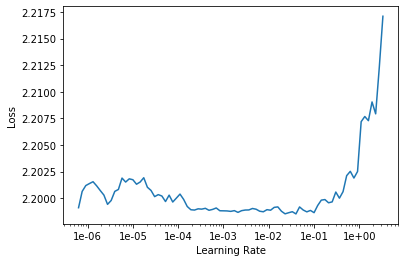

In [51]:
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(6, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.976511,2.004136,0.210329,00:53
1,1.708385,1.925961,0.309902,00:54
2,1.533214,1.730246,0.377991,00:53
3,1.364433,1.743475,0.380693,00:53
4,1.218660,1.722998,0.406196,00:54
5,1.196940,1.717270,0.408738,00:54


In [42]:
learn.fit_one_cycle(5, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.825057,1.887119,0.294569,00:44
1,1.584725,1.784854,0.362489,00:45
2,1.351885,1.718603,0.401947,00:45
3,1.215483,1.723908,0.416489,00:45
4,1.145814,1.725271,0.419600,00:45


In [44]:
learn.fit_one_cycle(5, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.228191,1.720652,0.418062,00:45
1,1.204702,1.754011,0.414089,00:45
2,1.080437,1.800883,0.421920,00:44
3,0.927321,1.812476,0.433911,00:45
4,0.893710,1.818390,0.434898,00:45


In [46]:
learn.fit_one_cycle(5, max_lr=3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.907149,1.834231,0.434960,00:45
1,0.867608,1.853974,0.433147,00:44
2,0.866601,1.868954,0.429964,00:45
3,0.827609,1.877962,0.432604,00:45
4,0.816124,1.875919,0.432649,00:45


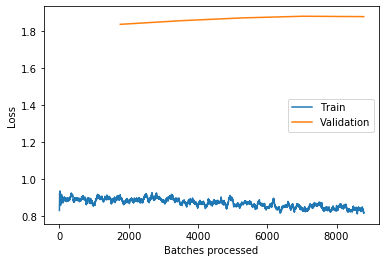

In [47]:
learn.recorder.plot_losses()

In [44]:
learn.fit(3, lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.081944,1.684694,0.423218,01:04
1,1.054919,1.700798,0.426871,01:05
2,0.994442,1.714176,0.438560,01:05


### Error Analysis

Investigate most commonly confused pairs at the fragment level.

In [45]:
interp = ClassificationInterpretation.from_learner(learn)

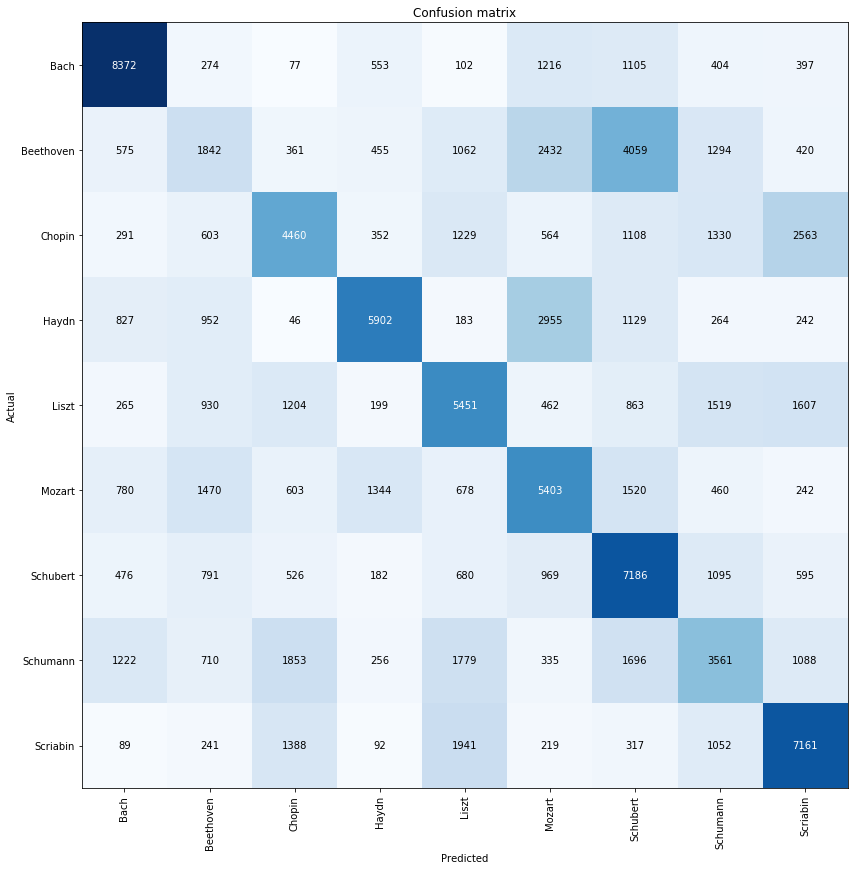

In [46]:
interp.plot_confusion_matrix(figsize=(12,12))

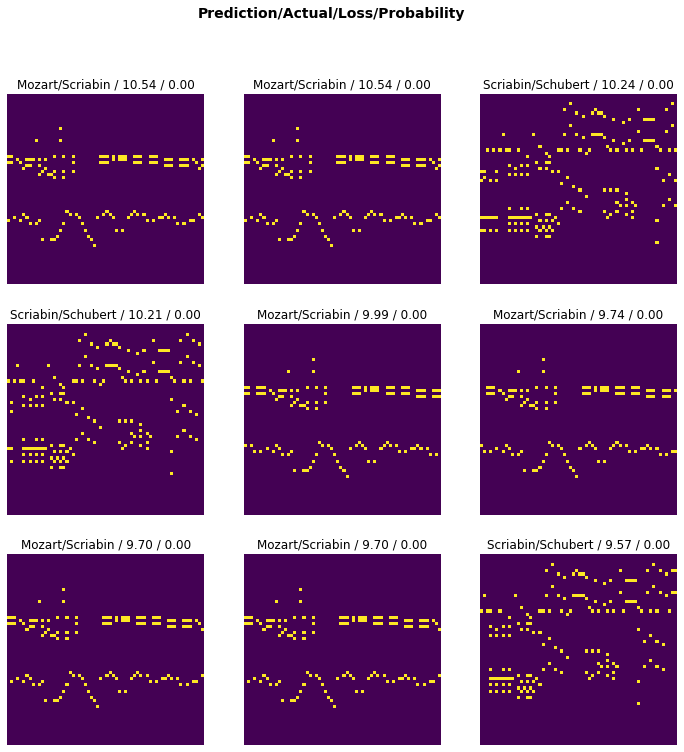

In [47]:
interp.plot_top_losses(9, figsize=(12,12))

In [48]:
def visualizeBootlegScore(bs, lines = [13, 15, 17, 19, 21, 35, 37, 39, 41, 43]):
    plt.figure(figsize = (10,10))
    plt.imshow(1 - bs, cmap = 'gray', origin = 'lower')
    for l in range(1, bs.shape[0], 2):
        plt.axhline(l, c = 'grey')
    for l in lines:
        plt.axhline(l, c = 'r')

In [49]:
def getBscoreData(interp, idx):
    return interp.data.valid_ds.x[idx].data[0]

In [50]:
def getImageInfo(interp, idx, pageinfo, nextPage = False):
    path = str(interp.data.valid_ds.items[idx]) # e.g. score_feat_imagenet/valid/Bach/valid_342.png
    m = re.search(r'valid_(\d+).png$', path)
    valid_idx = int(m.group(1))
    im = getCorrespondingImage(pageinfo[valid_idx], showNext = nextPage)
    return im, pageinfo[valid_idx]

In [51]:
def getCorrespondingImage(tup, png_dir = 'data/png', showNext = False):
    pieceDir, startLoc, endLoc = tup
    composer = pieceDir.split('/')[-3]
    pieceID = pieceDir.split('/')[-2]
    startpage = startLoc[1]
    if showNext:
        startpage += 1
    pngfile = '{}/{}/{}/{}-{}.png'.format(png_dir, composer, pieceID, pieceID, startpage)
    im = PIL.Image.open(pngfile)
    return im

In [52]:
losses, idxs = interp.top_losses()

In [56]:
i = 0
frag = getBscoreData(interp, idxs[i])
im, locInfo = getImageInfo(interp, idxs[i], pageinfo_valid, nextPage = False)
locInfo

('score_feat/Scriabin/58199/',
 (5.241758241758242, 5, 44),
 (5.631868131868131, 5, 115))

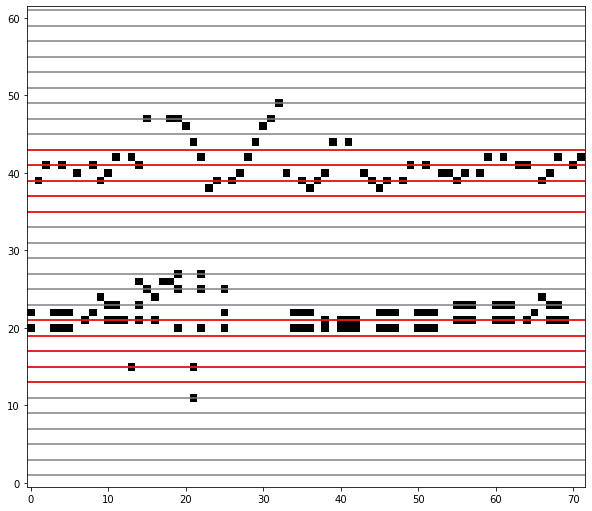

In [57]:
visualizeBootlegScore(frag)

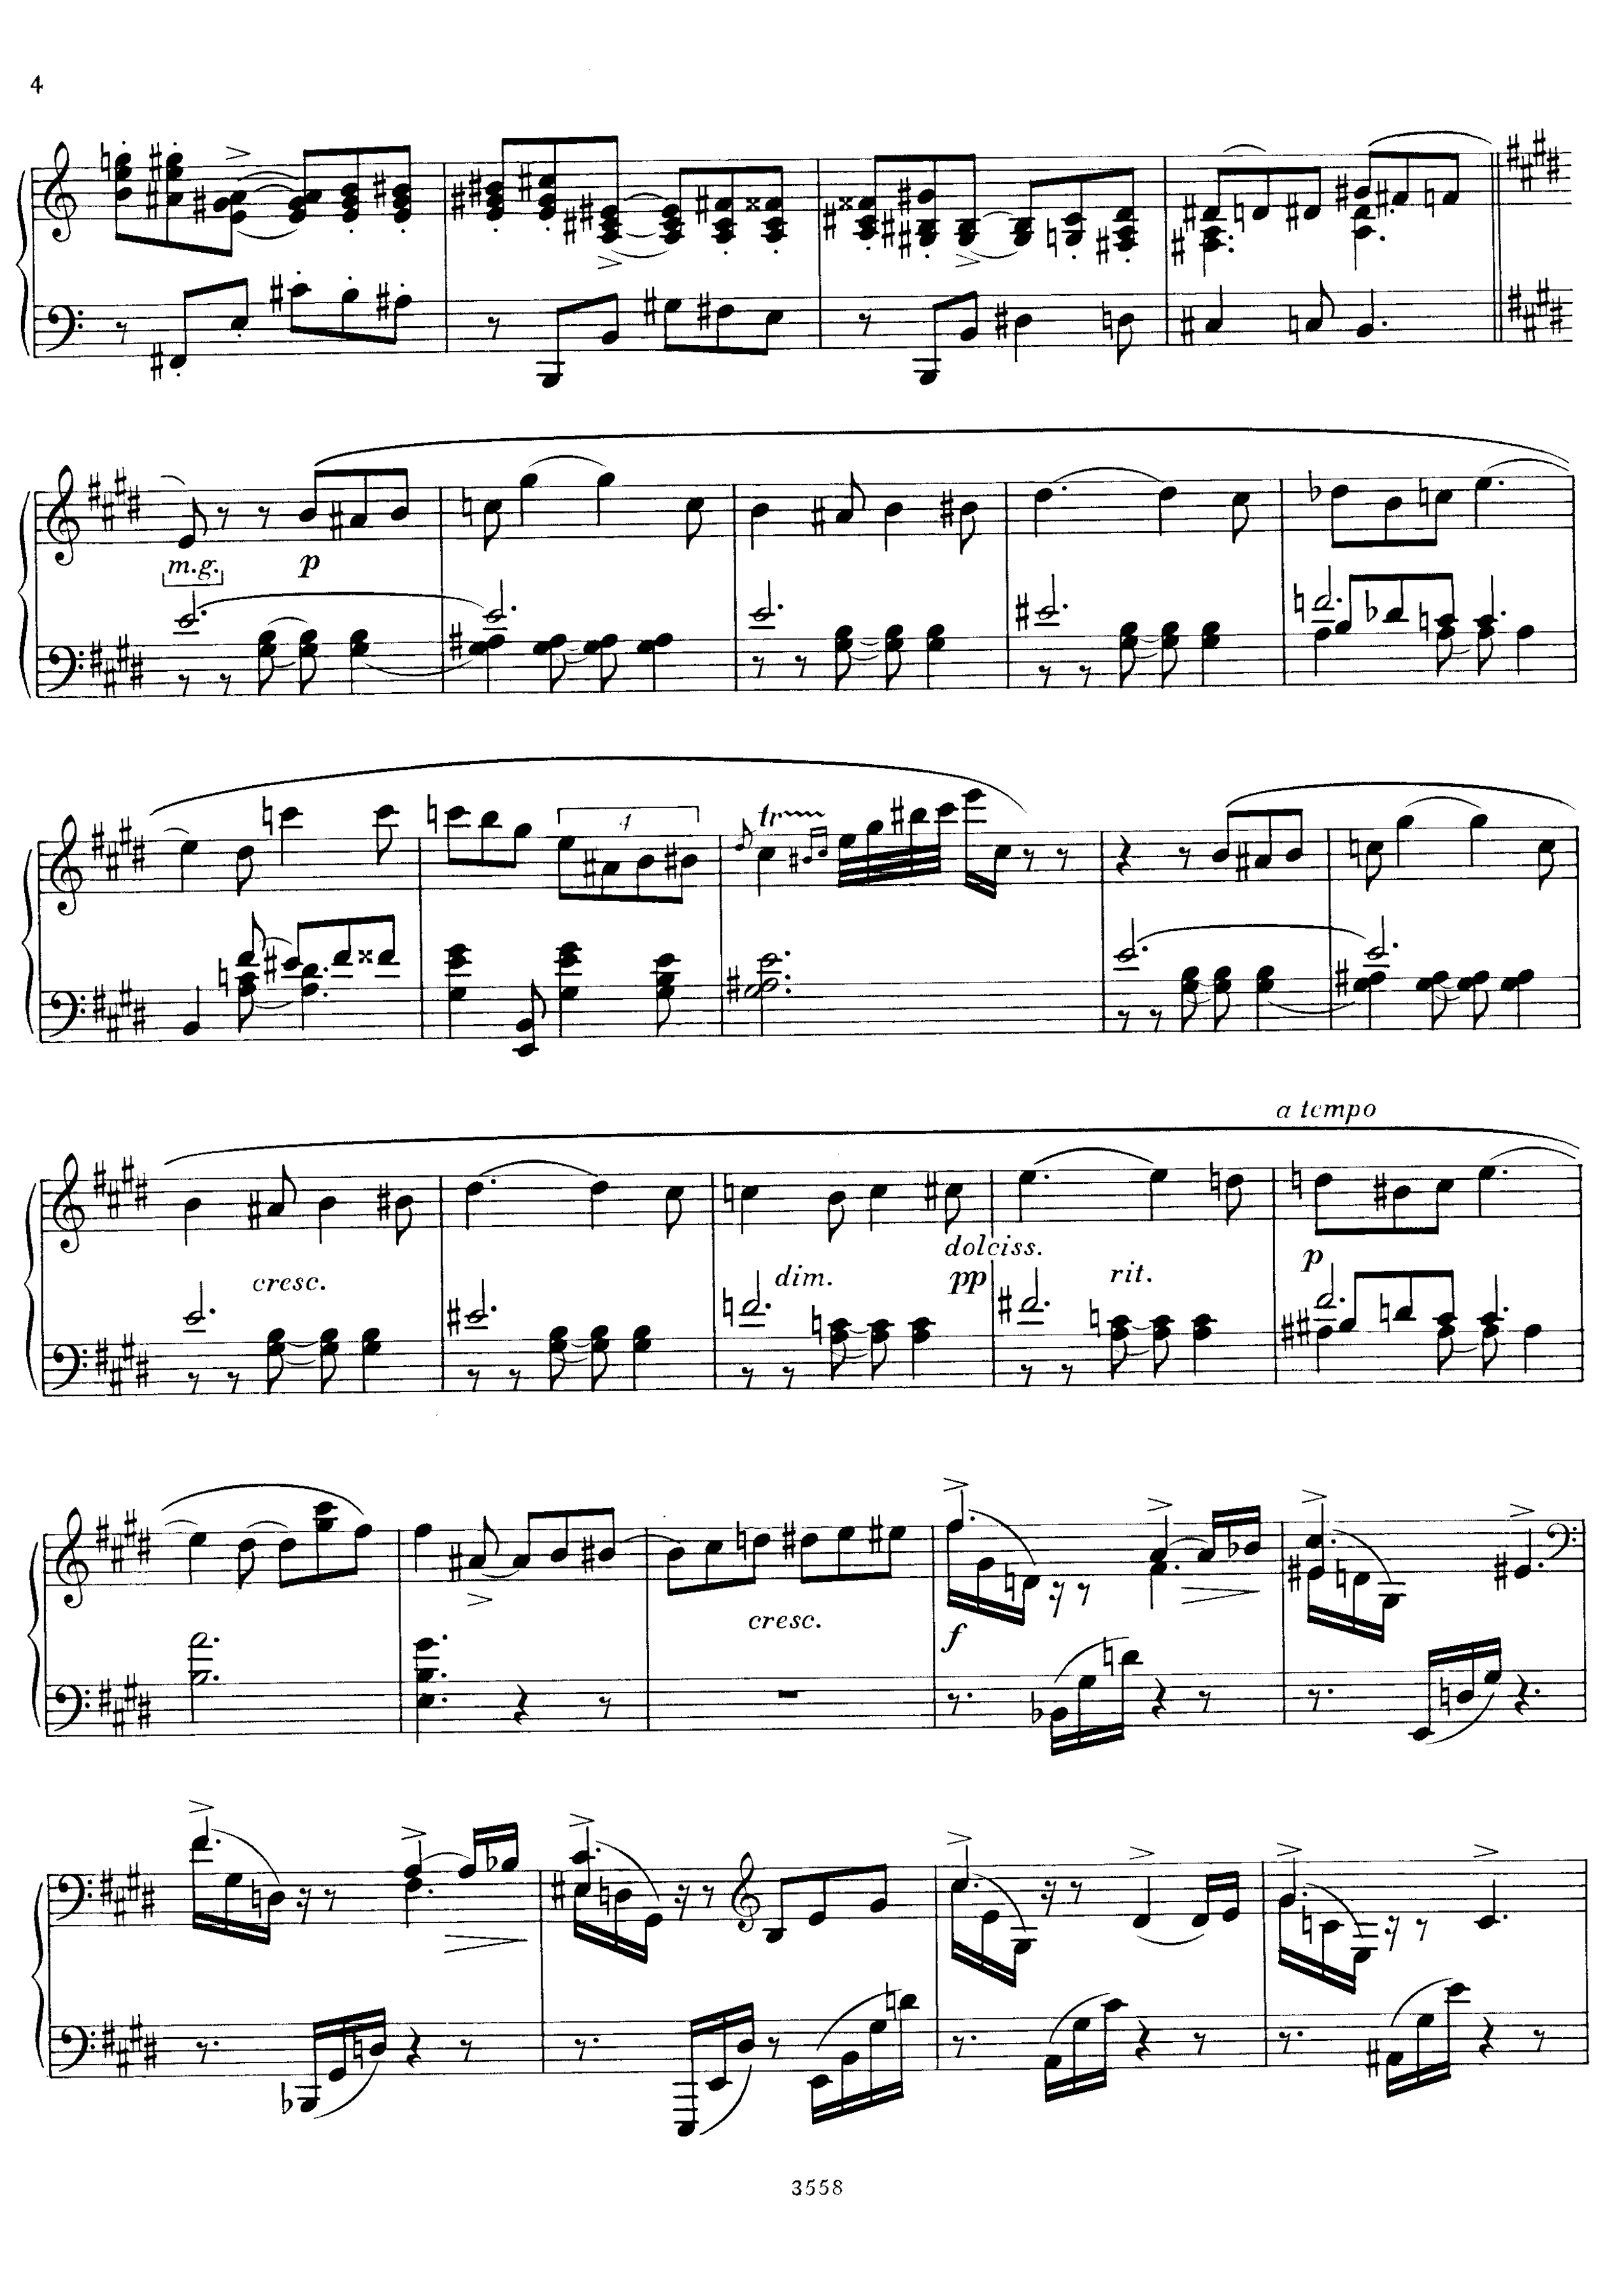

In [58]:
im

Now sort validation pieces in order of their classification accuracy.

In [59]:
def sortPiecesByAccuracy(interp, pageinfo):
    
    # accumulate counts for each piece
    d = {} # key: pieceDir, value: (composerIdx, predictionCounts)
    numClasses = len(interp.data.classes)
    for idx, tup in enumerate(interp.data.dl(interp.ds_type).dataset):
        gt_class = int(tup[1])
        pred_class = interp.pred_class[idx].item()
        _, locInfo = getImageInfo(interp, idx, pageinfo)
        pieceDir = locInfo[0]  # e.g. score_feat/Bach/06407/
        if pieceDir not in d:
            d[pieceDir] = (gt_class, np.zeros(numClasses))
        d[pieceDir][1][pred_class] += 1
    
    # sort pieces by accuracy
    def calcAcc(pieceDir):
        gt_class = d[pieceDir][0]
        ncorrect = d[pieceDir][1][gt_class]
        total = np.sum(d[pieceDir][1])
        return ncorrect / total
    pieceDirs = sorted(d.keys(), key=calcAcc)
    accuracies = [calcAcc(pd) for pd in pieceDirs]
    sorted_tups = list(zip(pieceDirs, accuracies))
    
    return sorted_tups, d

In [60]:
pieceDirs_sorted, predCounts = sortPiecesByAccuracy(interp, pageinfo_valid)

In [61]:
for i in range(10):
    pieceDir, acc = pieceDirs_sorted[i]
    gt_class = predCounts[pieceDir][0]
    ncorrect = predCounts[pieceDir][1][gt_class]
    total = np.sum(predCounts[pieceDir][1])
    print('{} | {}/{} = {:.1f}% | {} | {}'.format(pieceDir, int(ncorrect), int(total), 100*acc, gt_class, predCounts[pieceDir][1]))

score_feat/Beethoven/318762/ | 0/34 = 0.0% | 1 | [ 0.  0.  0.  0.  0.  0. 34.  0.  0.]
score_feat/Liszt/31926/ | 0/21 = 0.0% | 4 | [ 1.  3.  0.  1.  0.  0.  1.  0. 15.]
score_feat/Mozart/56677/ | 0/174 = 0.0% | 5 | [10. 51.  0. 64.  0.  0. 20.  0. 29.]
score_feat/Chopin/138636/ | 2/216 = 0.9% | 2 | [  0.   0.   2.   0.   1.   2.   0. 178.  33.]
score_feat/Beethoven/12832/ | 1/59 = 1.7% | 1 | [ 0.  1.  0.  0.  9. 12. 17.  6. 14.]
score_feat/Beethoven/419636/ | 76/1505 = 5.0% | 1 | [ 90.  76.  23.  34.  16.  85. 852. 240.  89.]
score_feat/Haydn/471800/ | 72/1231 = 5.8% | 3 | [ 30.  96.   2.  72.  25. 569. 294.  97.  46.]
score_feat/Schumann/77076/ | 128/1948 = 6.6% | 7 | [ 22. 254. 368. 163. 438. 120. 370. 128.  85.]
score_feat/Beethoven/377818/ | 30/384 = 7.8% | 1 | [ 51.  30.  89.   1.  23. 111.  57.  22.   0.]
score_feat/Schubert/27164/ | 16/194 = 8.2% | 6 | [  0.   7. 131.   0.  36.   0.  16.   2.   2.]


In [28]:
interp.data.classes

['Bach',
 'Beethoven',
 'Chopin',
 'Haydn',
 'Liszt',
 'Mozart',
 'Schubert',
 'Schumann',
 'Scriabin']